# Position and velocity: train 85\%

## Load data and make the sequences

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader


# Load the data and create a DataFrame
D = np.load('../data/DHOscillator_data.npy')
df = pd.DataFrame(D)
df.columns = ["time", "position", "velocity"]  

# Extract position and velocity as separate time series
timeseries_p = df[["position"]].values.astype('float32') 
timeseries_v = df[["velocity"]].values.astype('float32') 

# Extract time series for overall data
times = df[["time"]].values.astype('float32')
timeseries =  df[["position", "velocity"]]

# train-test split for time series
train_size = int(len(timeseries_p) * 0.85)
test_size = len(timeseries_p) - train_size
p_train, p_test = timeseries_p[:train_size], timeseries_p[train_size:]
v_train, v_test = timeseries_v[:train_size], timeseries_v[train_size:]
t_train, t_test = times[:train_size],times[train_size:]

# Function to create the dataset
def create_dataset(dataset_p, dataset_v,  lookback):
    X, y = [], []
    for i in range(len(dataset_p)-lookback):
        # Create feature by stacking lookback points of position and velocity
        feature = np.column_stack((dataset_p[i:i+lookback], dataset_v[i:i+lookback]))
        # Create target by stacking lookback+1 points of position and velocity
        target = np.column_stack((dataset_p[i+1:i+lookback+1],dataset_v[i+1:i+lookback+1]))  
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)
 
lookback = 4
X_train, y_train  = create_dataset(p_train, v_train,  lookback=lookback)

/tmp/ipykernel_1034225/528053897.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(X), torch.tensor(y)


### sequence example

In [2]:
import numpy as np
import torch

# Sample position dataset
dataset_p = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Sample velocity dataset
dataset_v = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


# Lookback value
lookback = 4

# Function to create dataset
def create_dataset(dataset_p, dataset_v, lookback):
    X, y = [], []
    for i in range(len(dataset_p)-lookback):
        feature = np.column_stack((dataset_p[i:i+lookback], dataset_v[i:i+lookback]))
        target = np.column_stack((dataset_p[i+1:i+lookback+1],dataset_v[i+1:i+lookback+1]))  
        time = times[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

# Call the create_dataset function
X, y = create_dataset(dataset_p, dataset_v, lookback)


In [3]:
# Print the generated feature sequences, target values, and time values
for i in range(len(X)):
    print(f"Features (X): {X[i]},\n Target (y): {y[i]}")

Features (X): tensor([[1.0000, 0.1000],
        [2.0000, 0.2000],
        [3.0000, 0.3000],
        [4.0000, 0.4000]], dtype=torch.float64),
 Target (y): tensor([[2.0000, 0.2000],
        [3.0000, 0.3000],
        [4.0000, 0.4000],
        [5.0000, 0.5000]], dtype=torch.float64)
Features (X): tensor([[2.0000, 0.2000],
        [3.0000, 0.3000],
        [4.0000, 0.4000],
        [5.0000, 0.5000]], dtype=torch.float64),
 Target (y): tensor([[3.0000, 0.3000],
        [4.0000, 0.4000],
        [5.0000, 0.5000],
        [6.0000, 0.6000]], dtype=torch.float64)
Features (X): tensor([[3.0000, 0.3000],
        [4.0000, 0.4000],
        [5.0000, 0.5000],
        [6.0000, 0.6000]], dtype=torch.float64),
 Target (y): tensor([[4.0000, 0.4000],
        [5.0000, 0.5000],
        [6.0000, 0.6000],
        [7.0000, 0.7000]], dtype=torch.float64)
Features (X): tensor([[4.0000, 0.4000],
        [5.0000, 0.5000],
        [6.0000, 0.6000],
        [7.0000, 0.7000]], dtype=torch.float64),
 Target (y): tensor

## Define the model and train it

In [8]:
history_RNN = []   

class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=2, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 2)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
    
# Learning rate and scheduler
lr = 0.001
factor = 0.9
patience = 250

 
model = RNNModel()
optimizer = optim.Adam(model.parameters(),lr=lr)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=factor, patience=patience)

loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        history_RNN.append([loss.item(), optimizer.param_groups[0]['lr']])
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = loss_fn(y_pred, y_train)

    print("Epoch %d: train MSE %.4e, lr %.4e" % (epoch, train_rmse,optimizer.param_groups[0]['lr']))


torch.save(model.state_dict(), '../models/DHOscillator_LSTM.pt')



Epoch 0: train MSE 4.5095e-02, lr 1.0000e-03
Epoch 100: train MSE 8.2342e-06, lr 5.9049e-04
Epoch 200: train MSE 1.6933e-06, lr 2.5419e-04
Epoch 300: train MSE 8.1233e-07, lr 9.8477e-05
Epoch 400: train MSE 5.9412e-07, lr 4.2391e-05
Epoch 500: train MSE 4.8175e-07, lr 1.4781e-05
Epoch 600: train MSE 4.2930e-07, lr 5.1538e-06
Epoch 700: train MSE 4.1390e-07, lr 1.6173e-06
Epoch 800: train MSE 4.0938e-07, lr 6.2658e-07
Epoch 900: train MSE 4.0793e-07, lr 1.9663e-07


[[1.46093607e-01 1.00000000e-03]
 [2.35404611e-01 1.00000000e-03]
 [1.93331271e-01 1.00000000e-03]
 ...
 [5.83616497e-07 9.40461087e-08]
 [1.55847545e-07 9.40461087e-08]
 [4.76687319e-07 9.40461087e-08]]


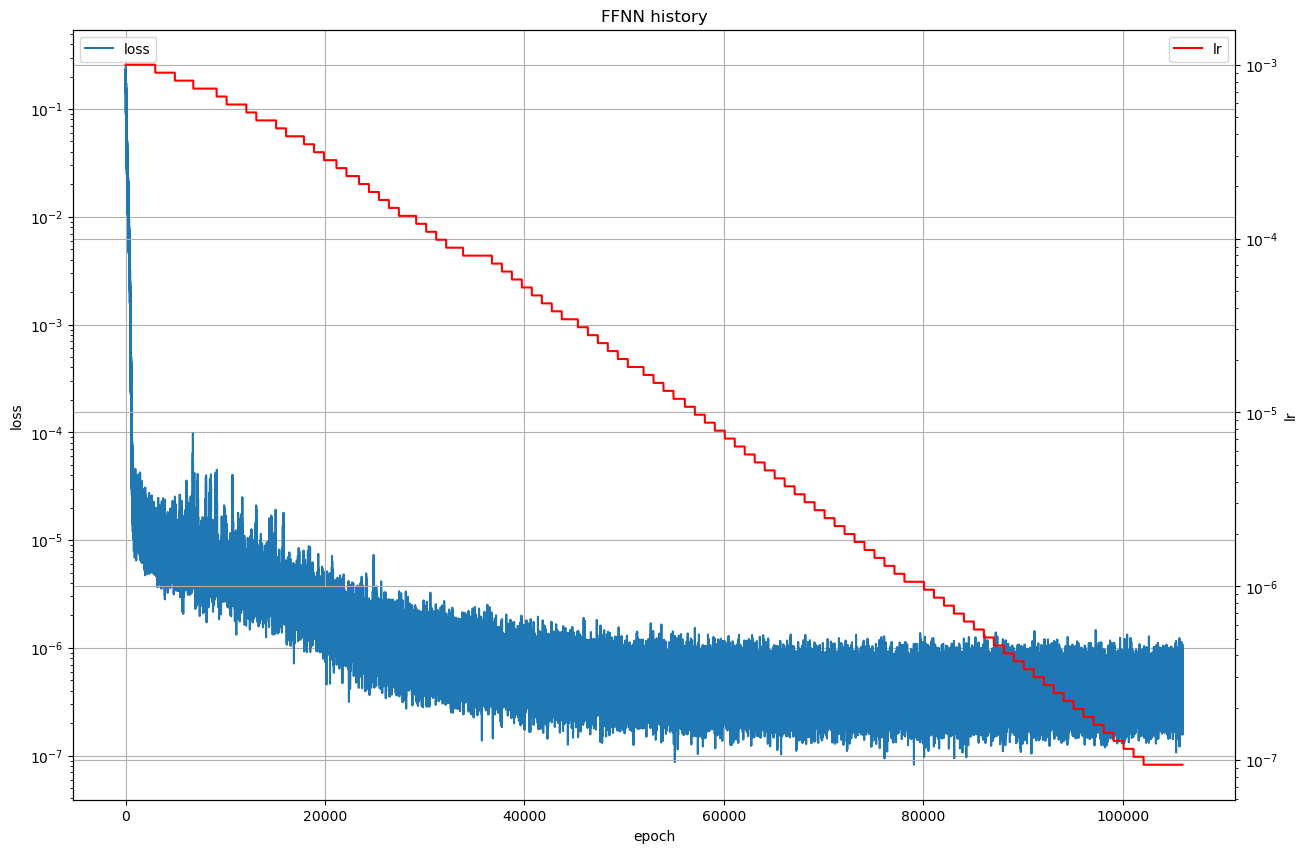

In [9]:
# plot history_FFNN loss and lr in two subplots
history_RNN = np.array(history_RNN)

print(history_RNN)
fig, ax = plt.subplots(figsize=(15, 10))
# plot the loss
ax.plot(history_RNN[:, 0], label='loss')
ax.legend(loc='upper left')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.grid()

# plot the learning rate
ax2 = ax.twinx()
ax2.plot(history_RNN[:, 1], label='lr', color='r')
ax2.set_yscale('log')
ax2.set_ylabel('lr')
# legend to the right
ax2.legend(loc='upper right')
plt.grid()
plt.title('FFNN history')

# save the figure
plt.savefig('../plot/DHOscillator_LSTM_baseline_history.png')

The RNNModel class consists of an LSTM layer with an input size of 2 (position and velocity) and a hidden size of 50, and a linear layer to map the hidden state to the output size of 2. The forward method defines the forward pass of the model.

The model is then instantiated and an Adam optimizer is used with the model parameters. The loss function is set to the mean squared error (MSELoss).

The training loop runs for n_epochs iterations. Within each epoch, the model is set to train mode with model.train(). Batches of training data are fed to the model, and the predicted output is calculated. The loss is computed between the predicted output and the ground truth output. The optimizer parameters are then zeroed, and the loss is backpropagated through the model using loss.backward(). The optimizer updates the model parameters with optimizer.step().

Every 100 epochs, the model is set to evaluation mode with model.eval(). The RMSE is calculated on the training data and printed for the corresponding epoch.

The model takes in a sequence of input data points, which include the current position and velocity as well as the previous 'lookback' observations. It uses these input points to learn patterns and relationships in the data. In this case, the model uses an LSTM (Long Short-Term Memory) layer, which is a type of recurrent neural network (RNN) capable of capturing long-term dependencies in sequential data. The LSTM layer processes the input sequence and produces a hidden representation for each input point. This hidden representation encodes the learned information about the data history. The model then passes the hidden states through a linear layer to generate the predicted next position and velocity values. 

## Predict values and Plot


In [10]:
import time
model = RNNModel()
model.load_state_dict(torch.load('../models/DHOscillator_LSTM.pt'))
model.eval()

# Initialize an empty plot for position, velocity, and time
train_plot_p = np.ones_like(timeseries_p) * np.nan
train_plot_v = np.ones_like(timeseries_v) * np.nan
test_plot_p = np.ones_like(timeseries_p) * np.nan
test_plot_v = np.ones_like(timeseries_v) * np.nan
train_plot_t = np.ones_like(timeseries_p) * np.nan
test_plot_t = np.ones_like(timeseries_p) * np.nan
train_true_p =np.ones_like(timeseries_p) * np.nan
train_true_v =np.ones_like(timeseries_p) * np.nan
test_true_p =np.ones_like(timeseries_p) * np.nan
test_true_v =np.ones_like(timeseries_p) * np.nan

with torch.no_grad():
    # Generate the model predictions for training and testing data
    train_last_p = model(X_train)[:, -1, 0].numpy()
    train_last_v = model(X_train)[:, -1, 1].numpy()
    train_plot_p[lookback:lookback + len(train_last_p)] = train_last_p.reshape(-1, 1)
    train_plot_v[lookback:lookback + len(train_last_p)] = train_last_v.reshape(-1, 1)
    train_true_p[lookback:lookback + len(train_last_p)] = timeseries_p[lookback:lookback + len(train_last_p)]
    train_true_v[lookback:lookback + len(train_last_p)] = timeseries_v[lookback:lookback + len(train_last_p)]
    train_plot_t[lookback:lookback + train_size] = times[lookback:lookback + train_size]

    input_seq_p = torch.from_numpy(train_last_p[-lookback:])
    input_seq_v = torch.from_numpy(train_last_v[-lookback:])
    input_seq = torch.stack([input_seq_p, input_seq_v], dim=1)
    input_seq = input_seq.view(1, 4, 2)
    p_test, v_test = [] , [] 

    start_time = time.time()

    for i in range(len(timeseries_p)-(train_size+lookback)):
        predicted = model(input_seq)
        p_test.append(predicted[:,-1, 0].item())
        v_test.append(predicted[:,-1, 1].item())
        new_line = predicted[:,-1,:].unsqueeze(0)
        input_seq = torch.cat([ input_seq,new_line], dim=1)
        input_seq = input_seq[:,1:,:]

    end_time = time.time()

    avg_execution_time_RNN = (end_time - start_time)/2#(len(timeseries_p)-(train_size+lookback))
    print("Execution time:", avg_execution_time_RNN, "seconds")

    test_last_p = np.array(p_test)
    test_last_v = np.array(v_test)
    test_plot_p[train_size:len(timeseries_p)-lookback] = test_last_p.reshape(-1, 1)
    test_plot_v[train_size:len(timeseries_v)-lookback] = test_last_v.reshape(-1, 1)
    test_true_p[train_size:len(timeseries_p)-lookback] = timeseries_p[train_size:len(timeseries_p)-lookback]
    test_true_v[train_size:len(timeseries_p)-lookback] = timeseries_v[train_size:len(timeseries_p)-lookback]
    test_plot_t[train_size:len(timeseries_p)-lookback] = times[train_size:len(timeseries_p)-lookback]


Execution time: 0.016109347343444824 seconds


In [11]:
from sklearn.metrics import mean_squared_error

# Remove nan values from the arrays
clean_test_true_p = test_true_p[~np.isnan(test_true_p)]
clean_test_true_v = test_true_v[~np.isnan(test_true_v)]
clean_test_pred_p = test_plot_p[~np.isnan(test_plot_p)]
clean_test_pred_v = test_plot_v[~np.isnan(test_plot_v)]

# Calculate RMSE for position and velocity
mse_p = mean_squared_error(clean_test_true_p, clean_test_pred_p)
mse_v = mean_squared_error(clean_test_true_v, clean_test_pred_v)

print("MSE Position:", mse_p)
print("MSE Velocity:", mse_v)

loss_RNN = (mse_p+mse_v)/2

MSE Position: 1.5378062e-05
MSE Velocity: 1.9134497e-05


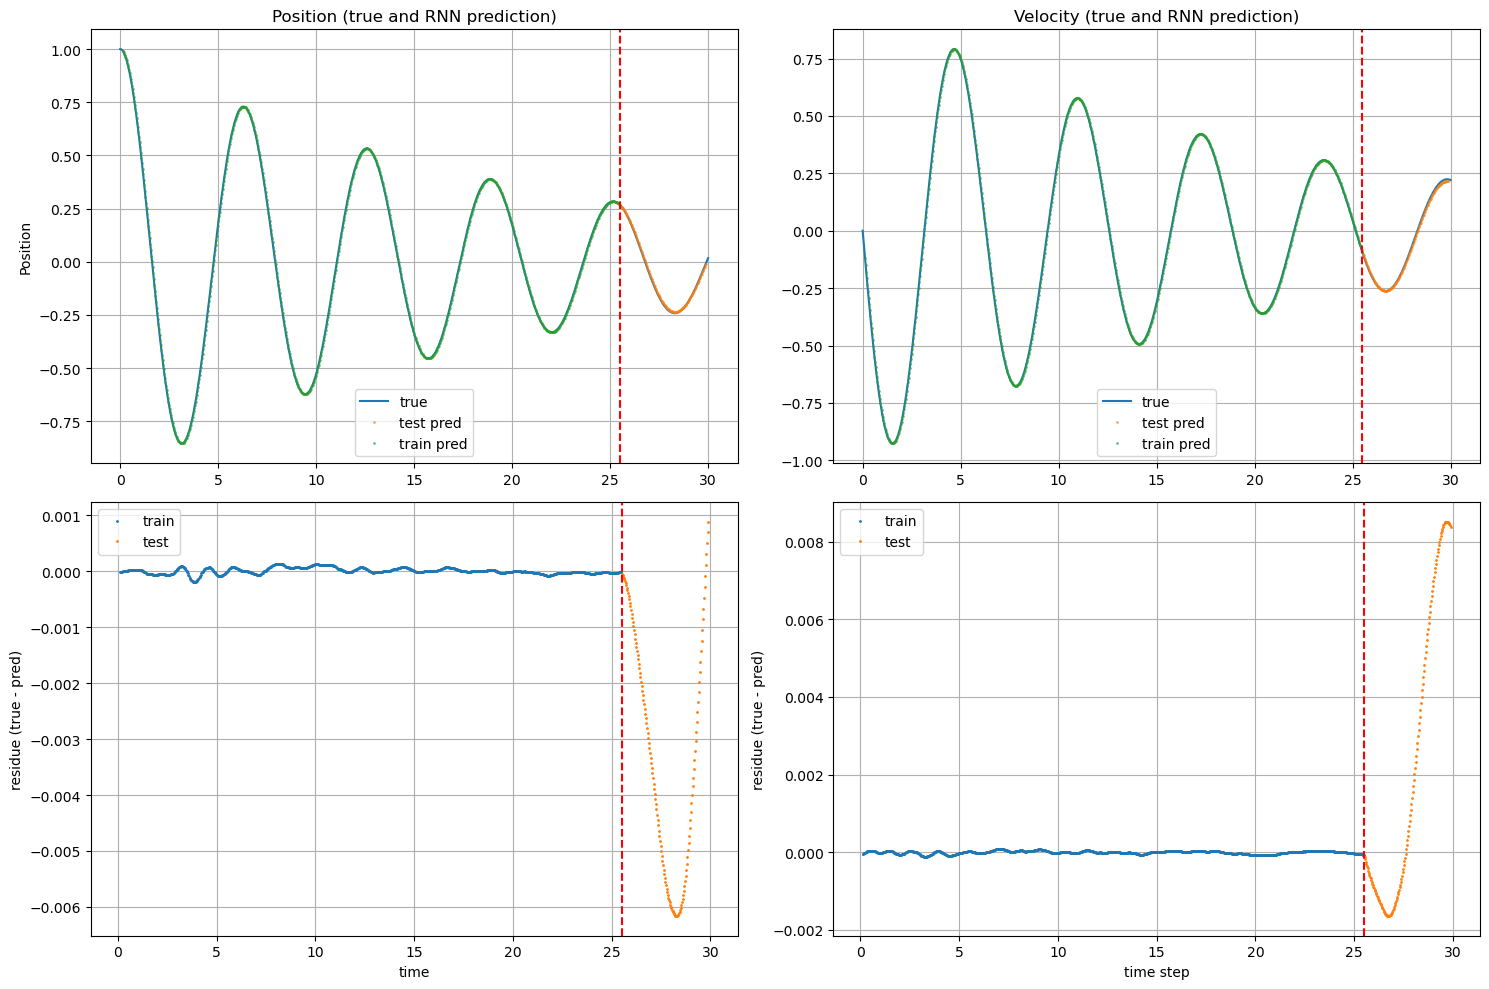

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# Position vs Time
plt.subplot(2, 2, 1)
plt.plot(times, timeseries_p, markersize=0.5, label='true')
plt.plot(test_plot_t, test_plot_p, '.', markersize=2, label='test pred', alpha=0.6)
plt.plot(train_plot_t, train_plot_p, '.', markersize=2, label='train pred', alpha=0.6)
plt.axvline(30*0.85, linestyle='--', color='r')
plt.grid()
plt.ylabel("Position")
plt.title("Position (true and RNN prediction)")
plt.legend()

# Velocity vs Time
plt.subplot(2, 2, 2)
plt.plot(times, timeseries_v, markersize=0.5, label='true')
plt.plot(test_plot_t, test_plot_v, '.', markersize=2, label='test pred', alpha=0.6)
plt.plot(train_plot_t, train_plot_v, '.', markersize=2, label='train pred', alpha=0.6)
plt.grid()
plt.axvline(30*0.85, linestyle='--', color='r')
plt.title("Velocity (true and RNN prediction)")
plt.legend()

# Difference in Position vs Time
plt.subplot(2, 2, 3)
plt.plot(train_plot_t, -train_plot_p + train_true_p, '.', markersize=2, label='train')
plt.plot(test_plot_t,- test_plot_p + test_true_p, '.', markersize=2, label='test')
plt.grid()
plt.axvline(30*0.85, linestyle='--', color='r')
plt.xlabel("time")
plt.ylabel('residue (true - pred)')
plt.legend()

# Difference in Velocity vs Time
plt.subplot(2, 2, 4)
plt.plot(train_plot_t, -train_plot_v + train_true_v, '.', markersize=2, label='train')
plt.plot(test_plot_t, -test_plot_v  +test_true_v, '.', markersize=2, label='test')
plt.grid()
plt.axvline(30*0.85, linestyle='--', color='r')
plt.xlabel("time step")
plt.ylabel('residue (true - pred)')
plt.legend()

plt.savefig('../plot/DHOscillator_LSTM.PDF')

plt.tight_layout()
plt.show()

Overall, the results of the model predictions are very promising and indicate that the model has learned the dynamics of the oscillator's position and velocity accurately. It demonstrates the effectiveness of the model in capturing the relationships in the given time series data and making reliable predictions.

# Train 25\%


Epoch 0: train MSE 2.8801e-01, lr 1.0000e-03
Epoch 100: train MSE 7.6362e-06, lr 5.3144e-04
Epoch 200: train MSE 6.4098e-06, lr 1.5009e-04
Epoch 300: train MSE 4.8173e-06, lr 3.4337e-05
Epoch 400: train MSE 4.2966e-06, lr 7.8552e-06


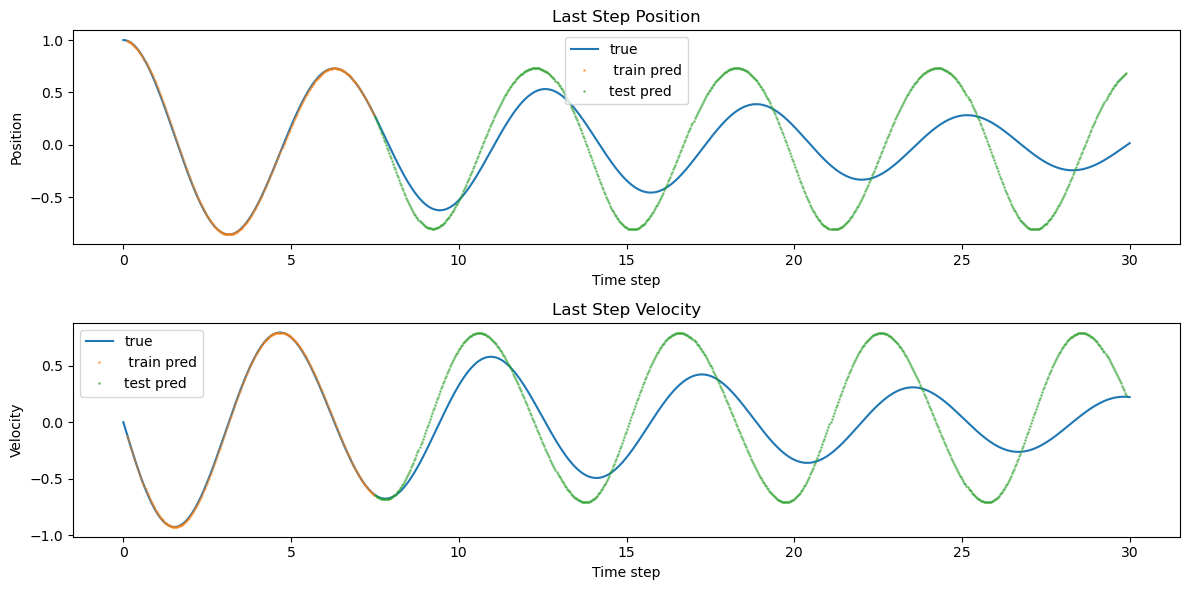

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader


D = np.load('../data/DHOscillator_data.npy')
df = pd.DataFrame(D)
df.columns = ["time", "position", "velocity"]  

timeseries_p = df[["position"]].values.astype('float32') 
timeseries_v = df[["velocity"]].values.astype('float32') 

times = df[["time"]].values.astype('float32')
timeseries =  df[["position", "velocity"]]

# train-test split for time series
train_size = int(len(timeseries_p) * 0.25)
test_size = len(timeseries_p) - train_size
p_train, p_test = timeseries_p[:train_size], timeseries_p[train_size:]
v_train, v_test = timeseries_v[:train_size], timeseries_v[train_size:]
t_train, t_test = times[:train_size],times[train_size:]

def create_dataset(dataset_p, dataset_v, times, lookback):
    X, y, t = [], [], []
    for i in range(len(dataset_p)-lookback):
        feature = np.column_stack((dataset_p[i:i+lookback], dataset_v[i:i+lookback]))
        target = np.column_stack((dataset_p[i+1:i+lookback+1],dataset_v[i+1:i+lookback+1]))  
        time = times[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
        t.append(time)
    return torch.tensor(X), torch.tensor(y), torch.tensor(t)
 
lookback = 4
X_train, y_train , t_train = create_dataset(p_train, v_train, t_train, lookback=lookback)
X_test, y_test, t_test = create_dataset(p_test, v_test, t_test, lookback=lookback)

# Learning rate and scheduler
lr = 0.001
factor = 0.9
patience = 250


model_1 = RNNModel()
optimizer = optim.Adam(model_1.parameters(),lr=lr)
loss_fn = nn.MSELoss()

loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=8)




scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=factor, patience=patience)

loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 500
for epoch in range(n_epochs):
    model_1.train()
    for X_batch, y_batch in loader:
        y_pred = model_1(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
    if epoch % 100 != 0:
        continue
    model_1.eval()
    with torch.no_grad():
        y_pred = model_1(X_train)
        train_rmse = loss_fn(y_pred, y_train)

    print("Epoch %d: train MSE %.4e, lr %.4e" % (epoch, train_rmse,optimizer.param_groups[0]['lr']))


# Initialize an empty plot for position, velocity, and time
train_plot_p = np.ones_like(timeseries_p) * np.nan
train_plot_v = np.ones_like(timeseries_v) * np.nan
test_plot_p = np.ones_like(timeseries_p) * np.nan
test_plot_v = np.ones_like(timeseries_v) * np.nan
train_plot_t = np.ones_like(timeseries_p) * np.nan
test_plot_t = np.ones_like(timeseries_p) * np.nan

with torch.no_grad():
    # Generate the model predictions for training and testing data
    train_last_p = model_1(X_train)[:, -1, 0].numpy()
    train_last_v = model_1(X_train)[:, -1, 1].numpy()
    train_plot_p[lookback:lookback + len(train_last_p)] = train_last_p.reshape(-1, 1)
    train_plot_v[lookback:lookback + len(train_last_p)] = train_last_v.reshape(-1, 1)
    train_plot_t[lookback:lookback + train_size] = times[lookback:lookback + train_size]

    input_seq_p = torch.from_numpy(train_last_p[-lookback:])
    input_seq_v = torch.from_numpy(train_last_v[-lookback:])
    input_seq = torch.stack([input_seq_p, input_seq_v], dim=1)
    input_seq = input_seq.view(1, 4, 2)
    p_test, v_test = [] , [] 
    for i in range(len(timeseries_p)-(train_size+lookback)):
        predicted = model_1(input_seq)
        p_test.append(predicted[:,-1, 0].item())
        v_test.append(predicted[:,-1, 1].item())
        new_line = predicted[:,-1,:].unsqueeze(0)
        input_seq = torch.cat([ input_seq,new_line], dim=1)
        input_seq = input_seq[:,1:,:]

    test_last_p = np.array(p_test)
    test_last_v = np.array(v_test)
    test_plot_p[train_size:len(timeseries_p)-lookback] = test_last_p.reshape(-1, 1)
    test_plot_v[train_size:len(timeseries_v)-lookback] = test_last_v.reshape(-1, 1)
    test_plot_t[train_size:len(timeseries_p)-lookback] = times[train_size:len(timeseries_p)-lookback]


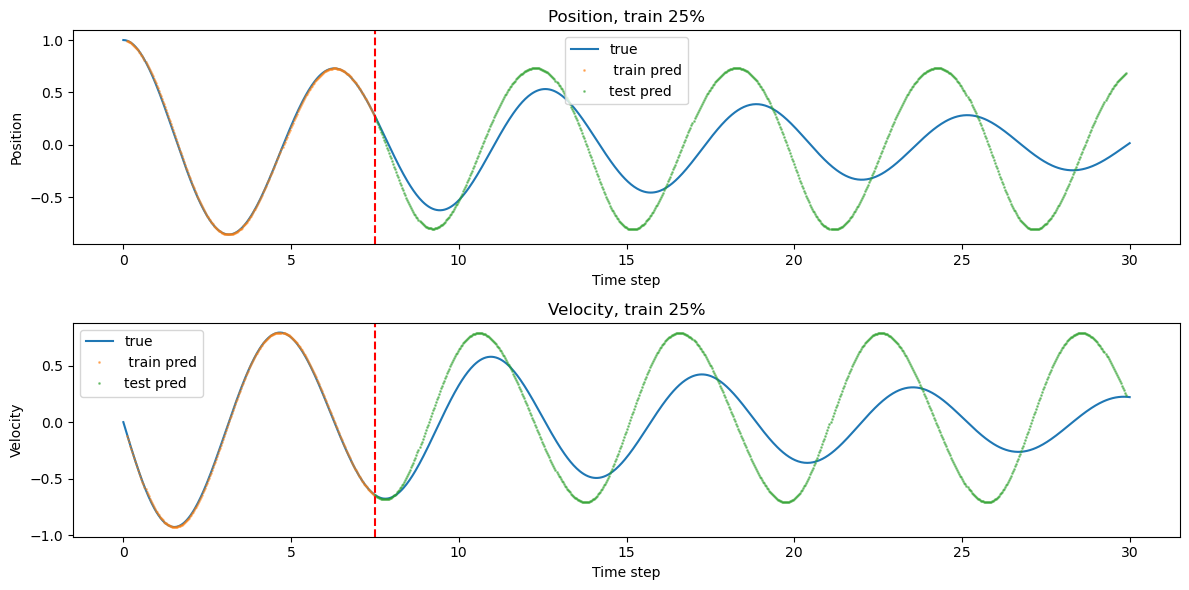

In [19]:

plt.figure(figsize=(12, 6))

# Position vs Time
plt.subplot(2, 1, 1)
plt.plot(times, timeseries_p,  markersize=0.5, label='true')
plt.plot(train_plot_t,train_plot_p, '.', markersize=2, label=' train pred',alpha=0.5)
plt.plot(test_plot_t,test_plot_p, '.', markersize=2, label='test pred',alpha=0.5)
plt.axvline(30*0.25, linestyle='--', color='r')
plt.xlabel("Time step")
plt.ylabel("Position")
plt.title("Position, train 25%")
plt.legend()

# Velocity vs Time
plt.subplot(2, 1, 2)
plt.plot(times, timeseries_v,  markersize=0.5, label='true')
plt.plot(train_plot_t, train_plot_v, '.', markersize=2, label=' train pred',alpha=0.5)
plt.plot(test_plot_t, test_plot_v, '.', markersize=2, label='test pred',alpha=0.5)
plt.axvline(30*0.25, linestyle='--', color='r')
plt.xlabel("Time step")
plt.ylabel("Velocity")
plt.title("Velocity, train 25%")
plt.legend()


plt.savefig('../data/DHOscillator_LSTM_25.pdf')
plt.tight_layout()
plt.show()




It is clear that the RNN is able to capture patterns in timeseries.